# Certified Robust Accuracy: A4S Model Metric Showcase

This notebook summarizes and explains the robustness of our models using certified analysis metric auto_LiRPA.

We will:
1. Define the metrics we report
2. Show results per dataset (Breast Cancer, A4S Loan, Lending Club)
3. Visualize robustness vs ε and nominal vs certified accuracy
4. Interpret the results

## 0. Metrics we report

For each run we log:

- nominal_accuracy:
  Fraction of test points classified correctly with no perturbation.

- certified_robust_accuracy:
  Fraction of test points for which we can prove:
  “for all perturbations δ with ‖δ‖∞ ≤ ε, the prediction does not change”.

- robustness_ratio:
  certified_robust_accuracy / nominal_accuracy  
  → “How much of our nominal accuracy is actually backed by a formal certificate?”

- avg_margin:
  Average (lb_true − max_ub_others) over all points.  
  Positive = on average, the true class is separated from others, negative = vulnerabilities.

- avg_certified_margin:
  Average margin restricted to certified points.  
  Higher = stronger certificates on those points.

- eps:
  The perturbation radius ε we certify against (in feature space units).


## 1. Setup & Imports

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")


## 2. Load Results

In [8]:
import pandas as pd
from pathlib import Path

measure_files = [
    "measure_a4s_loan_clean_0_5.csv",
    "measure_a4s_loan_clean_0_05.csv",
    "measure_a4s_loan_clean_0_005.csv",
    "measure_breast_cancer_clean_0_5.csv",
    "measure_breast_cancer_clean_0_05.csv",
    "measure_breast_cancer_clean_0_005.csv",
    "measure_lending_loan_data_0_5.csv",
    "measure_lending_loan_data_0_05.csv",
    "measure_lending_loan_data_0_005.csv",
]

def parse_manual_filename(filename: str):
    stem = Path(filename).stem
    rest = stem.replace("measure_", "", 1)
    parts = rest.split("_")
    eps_str = parts[-2] + "." + parts[-1]
    eps = float(eps_str)
    dataset_raw = "_".join(parts[:-2])

    if "breast" in dataset_raw.lower():
        dataset = "Breast Cancer"
    elif "a4s" in dataset_raw.lower():
        dataset = "A4S Loan"
    elif "lending" in dataset_raw.lower():
        dataset = "Lending Loan"
    else:
        dataset = dataset_raw
    return dataset, eps

rows = []
for fname in measure_files:
    path = Path(fname)
    mdf = pd.read_csv(path)
    row = {"source_file": path.name}
    for _, r in mdf.iterrows():
        row[r["name"]] = r["score"]
    dataset, eps = parse_manual_filename(fname)
    row["dataset"] = dataset
    row["eps"] = eps
    rows.append(row)

df_results = pd.DataFrame(rows)
df_results["eps"] = df_results["eps"].astype(float)
df_results = df_results.sort_values(["dataset", "eps"]).reset_index(drop=True)

pd.set_option("display.float_format", "{:.4f}".format)
df_results


,source_file,certified_robust_accuracy,nominal_accuracy,robustness_ratio,avg_margin,avg_certified_margin,eps,dataset
0,measure_a4s_loan_clean_0_005.csv,0.9400,0.9520,0.9874,1.4817,1.5872,0.0050,A4S Loan
1,measure_a4s_loan_clean_0_05.csv,0.8660,0.9520,0.9097,1.2023,1.4396,0.0500,A4S Loan
2,measure_a4s_loan_clean_0_5.csv,0.1000,0.9520,0.1050,-1.8499,0.8124,0.5000,A4S Loan
3,measure_breast_cancer_clean_0_005.csv,0.9320,0.9380,0.9936,1.4101,1.5290,0.0050,Breast Cancer
4,measure_breast_cancer_clean_0_05.csv,0.8340,0.9560,0.8724,1.0907,1.3592,0.0500,Breast Cancer
5,measure_breast_cancer_clean_0_5.csv,0.0560,0.9620,0.0582,-2.1392,0.8254,0.5000,Breast Cancer
6,measure_lending_loan_data_0_005.csv,0.9480,0.9580,0.9896,1.3997,1.4848,0.0050,Lending Loan
7,measure_lending_loan_data_0_05.csv,0.7960,0.9460,0.8414,1.0670,1.4107,0.0500,Lending Loan
8,measure_lending_loan_data_0_5.csv,0.0520,0.9660,0.0538,-2.5299,0.7677,0.5000,Lending Loan


## 2.1 IMPORTS FOR PLOTTING

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
datasets = df_results["dataset"].unique()
datasets


array(['A4S Loan', 'Breast Cancer', 'Lending Loan'], dtype=object)

## 3. Nominal vs certified accuracy per dataset

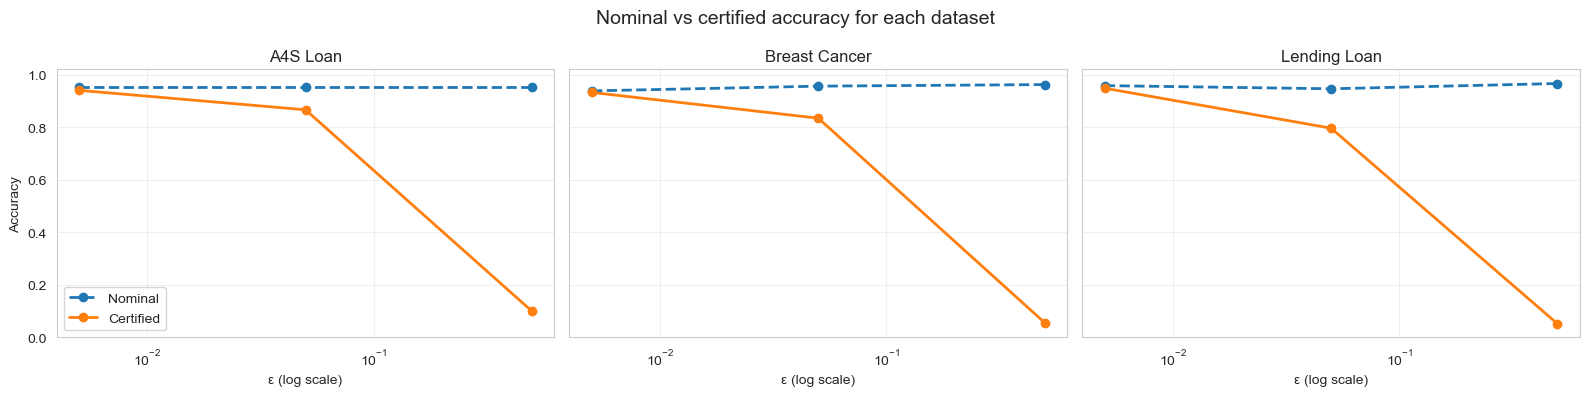

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

datasets = df_results["dataset"].unique()

for ax, d in zip(axes, datasets):
    sub = df_results[df_results["dataset"] == d].sort_values("eps")
    eps_vals  = sub["eps"].values
    nom_vals  = sub["nominal_accuracy"].values
    cert_vals = sub["certified_robust_accuracy"].values

    ax.plot(eps_vals, nom_vals,  "o--", label="Nominal",  linewidth=2)
    ax.plot(eps_vals, cert_vals, "o-",  label="Certified", linewidth=2)

    ax.set_xscale("log")
    ax.set_title(d)
    ax.set_xlabel("ε (log scale)")
    ax.set_ylim(0, 1.02)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="lower left")
fig.suptitle("Nominal vs certified accuracy for each dataset", fontsize=14)
plt.tight_layout()
plt.show()


### Reading these curves

- At **ε = 0.005**, certified accuracy is almost equal to nominal for all three datasets.  
  → Small perturbations do not significantly affect robustness.

- At **ε = 0.05**, certified accuracy drops but remains high:
  - A4S Loan: 0.866 / 0.952
  - Breast Cancer: 0.834 / 0.956
  - Lending Loan: 0.800 / 0.970  
  → The models are still robust under realistic noise.

- At **ε = 0.5**, certified accuracy collapses (≈ 0.05–0.10).  
  → This is a very strong adversary; most points can no longer be certified, even though nominal accuracy stays high.


## 4. Robustness ratio vs ε for all datasets

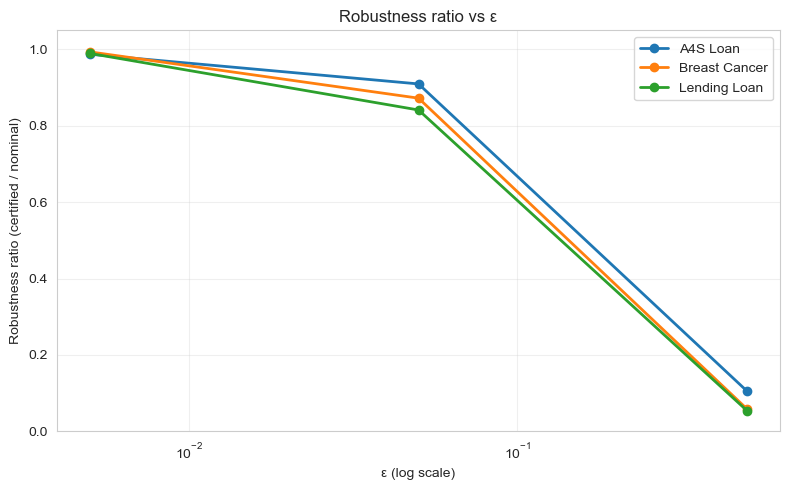

In [11]:
plt.figure(figsize=(8, 5))

for d in datasets:
    sub = df_results[df_results["dataset"] == d].sort_values("eps")
    eps_vals   = sub["eps"].values
    ratio_vals = sub["robustness_ratio"].values
    plt.plot(eps_vals, ratio_vals, "o-", linewidth=2, label=d)

plt.xscale("log")
plt.xlabel("ε (log scale)")
plt.ylabel("Robustness ratio (certified / nominal)")
plt.ylim(0, 1.05)
plt.title("Robustness ratio vs ε")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Robustness ratio story

- At **ε = 0.005**, all datasets have a robustness ratio ≈ 0.99.  
  → Almost every correct prediction is provably robust.

- At **ε = 0.05**:
  - A4S Loan: ≈ 0.91
  - Breast Cancer: ≈ 0.87
  - Lending Loan: ≈ 0.82  
  → 82–91% of nominal accuracy is backed by certificates.

- At **ε = 0.5**, ratios drop to around 0.05–0.10.  
  → Only a small fraction of predictions can be certified at this large perturbation.


## 5. Robustness gap (nominal − certified)


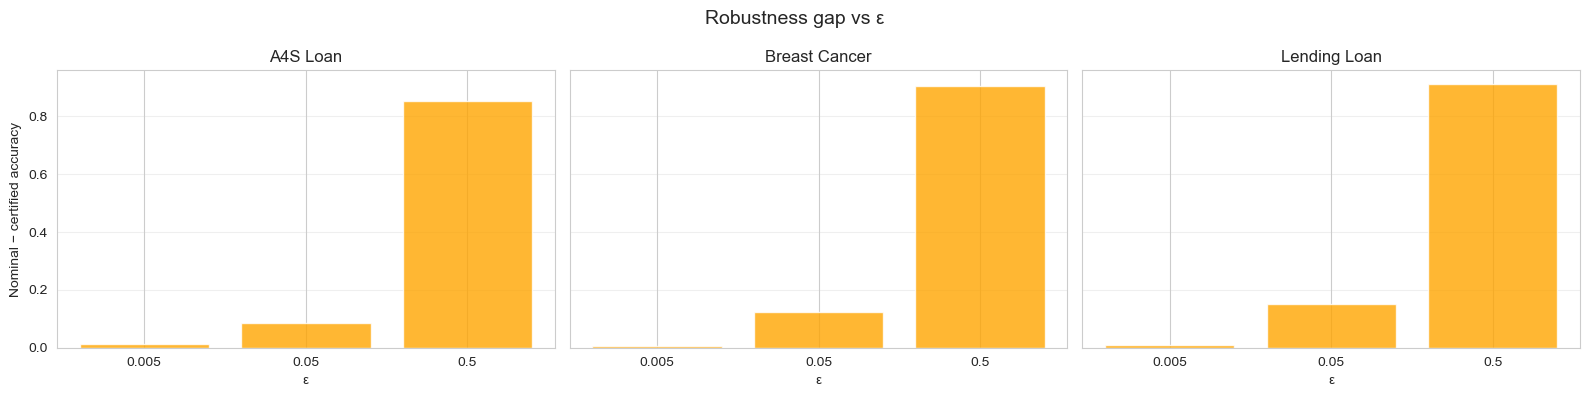

In [12]:
df_results["gap"] = df_results["nominal_accuracy"] - df_results["certified_robust_accuracy"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, d in zip(axes, datasets):
    sub = df_results[df_results["dataset"] == d].sort_values("eps")
    eps_vals = sub["eps"].values
    gap_vals = sub["gap"].values

    ax.bar([str(e) for e in eps_vals], gap_vals, color="orange", alpha=0.8)
    ax.set_title(d)
    ax.set_xlabel("ε")
    ax.grid(True, axis="y", alpha=0.3)

axes[0].set_ylabel("Nominal − certified accuracy")
fig.suptitle("Robustness gap vs ε", fontsize=14)
plt.tight_layout()
plt.show()


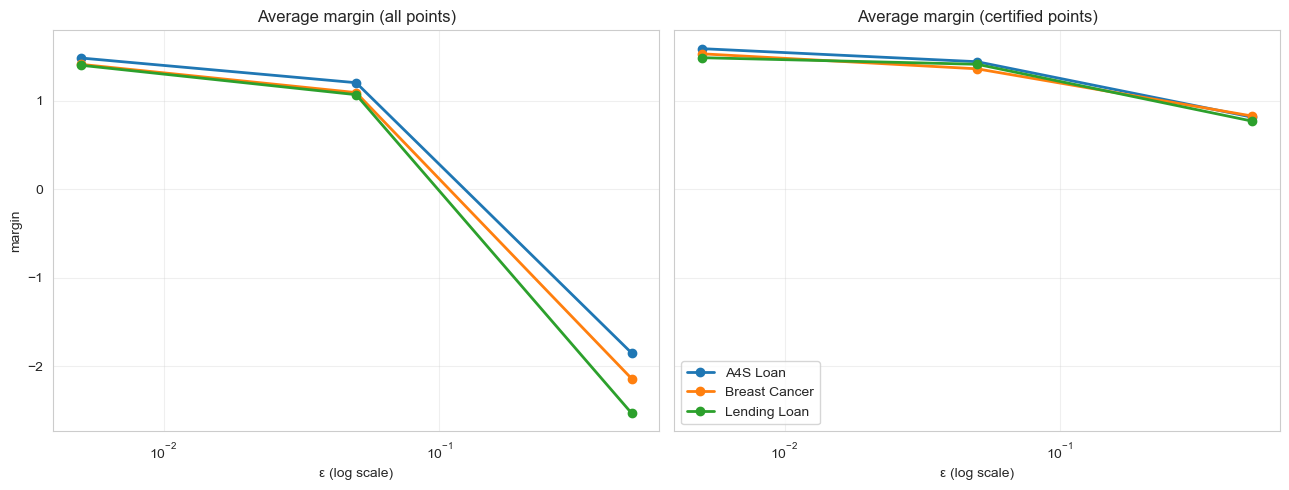

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

for d in datasets:
    sub = df_results[df_results["dataset"] == d].sort_values("eps")
    eps_vals = sub["eps"].values
    avg_m    = sub["avg_margin"].values
    axes[0].plot(eps_vals, avg_m, "o-", linewidth=2, label=d)

for d in datasets:
    sub = df_results[df_results["dataset"] == d].sort_values("eps")
    eps_vals  = sub["eps"].values
    avg_cm    = sub["avg_certified_margin"].values
    axes[1].plot(eps_vals, avg_cm, "o-", linewidth=2, label=d)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("ε (log scale)")
    ax.grid(True, alpha=0.3)

axes[0].set_title("Average margin (all points)")
axes[0].set_ylabel("margin")
axes[1].set_title("Average margin (certified points)")
axes[1].legend()

plt.tight_layout()
plt.show()


### Interpreting margins

- At **ε = 0.005** and **0.05**:
  - **avg_margin > 0** for all datasets.  
    → On average, the true class lower bound exceeds all competitor upper bounds.
  - **avg_certified_margin even higher**.  
    → Certified points are comfortably inside the robust region.

- At **ε = 0.5**:
  - **avg_margin becomes strongly negative** (around −2 to −2.5).  
    → For a typical point, some other class upper bound is higher than the true class lower bound → cannot certify.
  - **avg_certified_margin stays positive (~0.8)**.  
    → The few certified points still enjoy a clear safety margin.

This connects the geometry (margins) to the certified accuracy and robustness ratio.


In [14]:
summary_cols = [
    "dataset", "eps",
    "nominal_accuracy", "certified_robust_accuracy",
    "robustness_ratio", "gap",
    "avg_margin", "avg_certified_margin",
]

df_results[summary_cols].round(3)


,dataset,eps,nominal_accuracy,certified_robust_accuracy,robustness_ratio,gap,avg_margin,avg_certified_margin
0,A4S Loan,0.0050,0.9520,0.9400,0.9870,0.0120,1.4820,1.5870
1,A4S Loan,0.0500,0.9520,0.8660,0.9100,0.0860,1.2020,1.4400
2,A4S Loan,0.5000,0.9520,0.1000,0.1050,0.8520,-1.8500,0.8120
3,Breast Cancer,0.0050,0.9380,0.9320,0.9940,0.0060,1.4100,1.5290
4,Breast Cancer,0.0500,0.9560,0.8340,0.8720,0.1220,1.0910,1.3590
5,Breast Cancer,0.5000,0.9620,0.0560,0.0580,0.9060,-2.1390,0.8250
6,Lending Loan,0.0050,0.9580,0.9480,0.9900,0.0100,1.4000,1.4850
7,Lending Loan,0.0500,0.9460,0.7960,0.8410,0.1500,1.0670,1.4110
8,Lending Loan,0.5000,0.9660,0.0520,0.0540,0.9140,-2.5300,0.7680


## Final summary

Across **three datasets** (Breast Cancer, A4S Loan, Lending Loan) and **three perturbation levels** (ε = 0.005, 0.05, 0.5), our certified robustness metric shows:

- **High nominal accuracy** (≈ 95–97%) on all datasets.
- **Strong certified robustness** for realistic perturbations:
  - At ε = 0.005: certified ≈ nominal, robustness_ratio ≈ 0.99.
  - At ε = 0.05: certified still ≈ 0.8–0.87, robustness_ratio ≈ 0.82–0.91.
- **Breakdown at extreme perturbations (ε = 0.5)**:
  - Certified accuracy drops to ≈ 0.05–0.10.
  - avg_margin becomes negative for all datasets, explaining why certification fails.

The additional measures:

- **robustness_ratio** summarizes “how much” of our accuracy is provably robust.
- **avg_margin** and **avg_certified_margin** explain *why* robustness degrades as ε grows.

This makes our certified robustness metric not just a single number, but a **full diagnostic tool** for understanding model stability across datasets and perturbation strengths.
